# 2D effective index approximation of 3D simulations

Large-scale 3D FDTD simulations are often required for accurate results but are associated with significant time and costs. Therefore, the development of methods to approximate 3D simulations using 2D models presents notable advantages. For instance, during the initial phase of design exploration, employing 2D simulations can effectively narrow down the range of parameters, with 3D simulations subsequently refining and finalizing the design.

This notebook introduces an efficient index approximation method that enables the approximation of 3D FDTD simulations through 2D simulations, substantially reducing computational resources and simulation times, potentially by orders of magnitude, while still retaining a reasonable level of accuracy. This method is particularly suitable for modeling integrated photonic devices that support waveguide modes. We first outline the process for calculating the effective permittivity for the 2D simulation using the variational method.

Following this, we compare outcomes from both 2D and 3D simulations using various real devices as examples to validate the approximation method's effectiveness. The findings indicate that, when applied appropriately, the 2D simulation maintains an acceptable fidelity to the corresponding 3D response.

<img src="img/effective_index_approximation.png" width="500" alt="Schematic of 2D-ifying">

First we start by importing the necessary libraries for our simulations:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gdstk

import tidy3d as td
import tidy3d.web as web

## Variational Effective Permittivity

In order to match the material of our 2D structures with those of the corresponding 3D structures, we will calculate the <b>variational effective permittivity</b>, taken from `Manfred Hammer and Olena V. Ivanova, "Effective index approximations of photonic crystal slabs: a 2-to-1-D assessment," Opt Quant Electron 41, 267–283 (2009)`[DOI:10.1007/s11082-009-9349-3](https://doi.org/10.1007/s11082-009-9349-3):<br>
<center>
$\epsilon_{eff}(x,y)=n_{eff}(x,y)^2+\frac{\int_z[\epsilon(x,y,z)-\epsilon_{ref}(x,y,z,\omega)]|M(z,\omega)|^2dz}{\int_z|M(z,\omega)|^2dz},$
</center><br>
where $n_{eff}(x,y)$ is the effective index of the slab waveguide given the permittivity profile in the z direction, $\epsilon_{ref}$ is the reference slab permittivity profile in z, $\epsilon$ is the permittivity profile in z at the point at which you're calculating, and $M(z,\omega)$ is the mode profile in $z$. This formula is based off of the assumption that the different vertical slab modes remain relatively uncoupled.<br><br>

The reference profile in $z$ is a point $(x_r,y_r)$ that we choose to compare other $z$ profiles against. In our examples, we choose this point to include the location of our waveguide. Since, at the reference point, $\epsilon(x_r,y_r,z)=\epsilon_{ref}(x_r,y_r,z)$, the effective permittivity is simply $n_{eff}(x,y)^2$. Outside the waveguide, the integrand becomes nonzero so we must carry out the integral numerically.<br><br>

Note: This is only the effective permittivity for the TE mode. A separate TM mode formula exists, and the interested user should refer to the TM formula given in the paper.

In [2]:
import scipy.interpolate

def var_eps_eff(point, ref_point, sim, wavelength=1.55, inf=1000):
    """
    To calculate the vertical slab mode at 'point', we will create a 2D slice of the given simulation at
    'point' that extends in the yz plane infinitely, ensuring that it captures the entire permittivity
    profile. Then, to find the 1D mode profile, we use the Tidy3D ModeSolver on a plane at 'point' that
    extends infinitely in the xz plane. This intersection results in the ModeSolver operating on a line
    at 'point' that covers its entire z profile. We then use this to solve for n_eff and M in the above
    formula.
    """
    sim_2d_center = (point[0], point[1], 0)
    sim_2d_size = (0, inf, inf)
    sim_2d = sim.updated_copy(center=sim_2d_center,
                              size=sim_2d_size,
                              sources=[],
                              monitors=[],
                              boundary_spec=sim.boundary_spec.updated_copy(x=td.Boundary.periodic())
                             )
    # Now solving for mode at 'point'
    mode_solver_plane = td.Box(center=sim_2d.center, size=(td.inf, 0, td.inf))
    mode_solver = td.plugins.mode.ModeSolver(simulation=sim_2d,
                                             plane=mode_solver_plane,
                                             mode_spec=td.ModeSpec(num_modes=1),
                                             freqs=[td.C_0/wavelength])
    mode_data = mode_solver.solve()
    
    # get n_eff from the solver
    n_eff = mode_data.n_eff.item()
    if point == ref_point: return n_eff**2 # if point is the reference point, the integral is 0

    # get z permittivity profile at reference point
    x_ref, y_ref = ref_point
    eps_ref = sim.epsilon(box=td.Box(center=(x_ref, y_ref, list(sim.center)[2]), size=(0,0,td.inf)))
    
    # get z permittivity profile at 'point'
    x, y = point
    eps = sim.epsilon(box=td.Box(center=(x, y, list(sim.center)[2]), size=(0,0,td.inf)))
    
    eps_dif = np.squeeze(eps.values) - np.squeeze(eps_ref.values)

    # get M at the same z coordinates as those of (eps - eps_ref) so we can integrate their product
    z_coords = eps_ref.z.values
    mode_profile = mode_data.Ex
    Mz2 = scipy.interpolate.interp1d(x=mode_profile.z.values, y=np.abs(np.squeeze(mode_profile.values))**2)
    m_values = Mz2(z_coords)

    # calculate integrals
    num, denom = np.trapz(y=eps_dif*m_values, x=z_coords), np.trapz(y=m_values, x=z_coords)
    return n_eff**2 + num/denom

## Example 1: Strip to slot waveguide converter
To see this in action, we will apply this to some of the [strip to slot waveguide converter](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/StripToSlotConverters.html) examples in our library.<br>
### First Design

<img src="img/strip_to_slot_1.png" width="400" alt="Schematic of the first strip to slot converter design">

First we quickly build "Design 1," simply copying the values from the notebook.

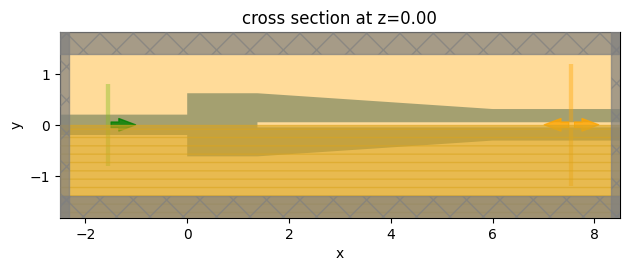

In [3]:
lda0 = 1.55
ldas = np.linspace(1.5, 1.6, 101)
freq0 = td.C_0 / lda0
freqs = td.C_0 / ldas
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))

h_si = 0.25
w_strip = 0.4
w_slot = 0.62
g = 0.1

n_si = 3.47  # silicon refractive index
si = td.Medium(permittivity=n_si**2)
n_sio2 = 1.44  # silicon oxide refractive index
sio2 = td.Medium(permittivity=n_sio2**2)

L_mmi = 1.38
W_mmi = 1.24
L = 6
buffer = 5

vertices = [
    (-buffer, w_strip / 2),
    (0, w_strip / 2),
    (0, W_mmi / 2),
    (L_mmi, W_mmi / 2),
    (L, w_slot / 2),
    (L + buffer, w_slot / 2),
    (L + buffer, g / 2),
    (L_mmi, g / 2),
    (L_mmi, -g / 2),
    (L + buffer, -g / 2),
    (L + buffer, -w_slot / 2),
    (L, -w_slot / 2),
    (L_mmi, -W_mmi / 2),
    (0, -W_mmi / 2),
    (0, -w_strip / 2),
    (-buffer, -w_strip / 2),
]

converter = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-h_si / 2, h_si / 2)), medium=si
)

mode_spec = td.ModeSpec(num_modes=3, target_neff=n_si) # Launch TE0 mode
mode_source = td.ModeSource(
    center=(-lda0, 0, 0),
    size=(0, 4 * w_strip, 6 * h_si),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
    num_freqs=7,
)

mode_monitor = td.ModeMonitor(
    center=(L + lda0, 0, 0),
    size=(0, 6 * w_strip, 6 * h_si),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

Lx = L + 3 * lda0
Ly = W_mmi + lda0
Lz = 10 * h_si
sim_size = (Lx, Ly, Lz)

run_time = 1e-12

sim_3d = td.Simulation(
    center=(L / 2, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
    structures=[converter],
    sources=[mode_source],
    monitors=[mode_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
    symmetry=(0, -1, 1),
)

sim_3d.plot(z=0)
plt.show()

Since the method that calculates the variational effective permittivity creates a 2D simulation from the given 3D simulation, there will likely be some objects not included in the 2D simulation, which will throw some warnings. Since we're okay with this, we'll suppress the warnings.

In [4]:
# Suppress warnings for some of the structures not being included in the 2D simulation
td.config.logging_level = 'ERROR'

Next we calculate the variational effective indices at different steps in our input wavelengths. We will then fit a dispersive material to this data using Tidy3D's FastDispersionFitter.

In [5]:
step = 6
reference_point = (0,0)
waveguide_eps, background_eps = [], []
for wl in ldas[::step]:
    waveguide_eps.append(var_eps_eff((0,0), reference_point, sim_3d, wavelength=wl))
    background_eps.append(var_eps_eff((0,1), reference_point, sim_3d, wavelength=wl))

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/tidy3d/components/types.py:71: ComplexWarning: Casting complex values to real discards the imaginary part
  arr_numpy = np.array(val, ndmin=1, dtype=cls.dtype, copy=True)


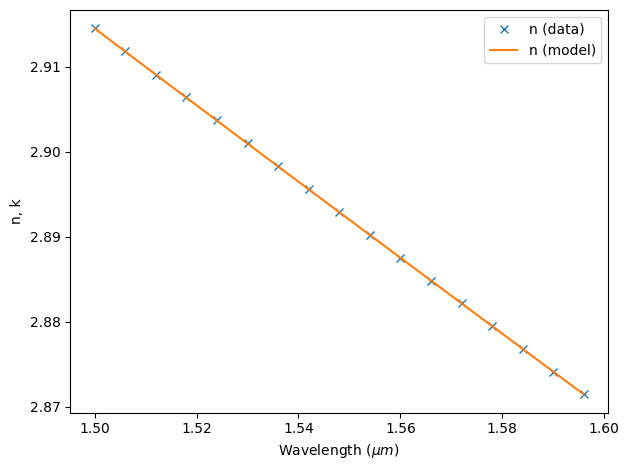

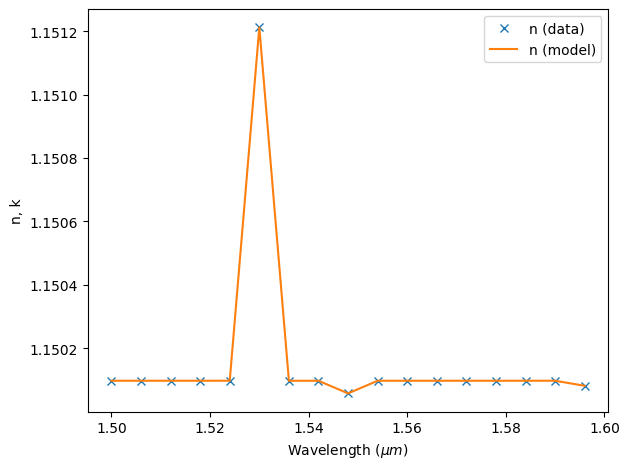

In [6]:
from tidy3d.plugins.dispersion import FastDispersionFitter

waveguide_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(waveguide_eps))
background_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(background_eps))
waveguide_medium, rms_error = waveguide_fitter.fit()
background_medium, rms_error = background_fitter.fit()
waveguide_fitter.plot(waveguide_medium)
background_fitter.plot(background_medium)
plt.show()

We now create the 2D simulation with the calculated 2D mediums:

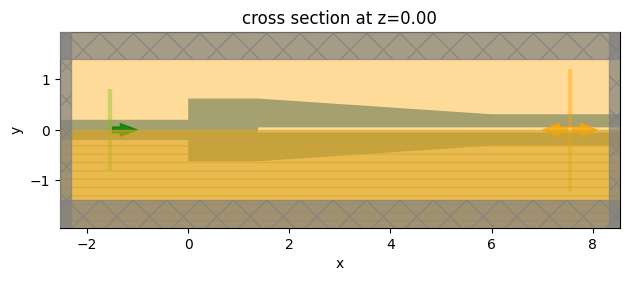

In [7]:
new_structures = []
for structure in sim_3d.structures:
    new_structures.append(structure.updated_copy(medium=waveguide_medium))

new_size = list(sim_3d.size)
new_size[2] = 0

new_symmetry = list(sim_3d.symmetry)
new_symmetry[2] = 0

sim_2d = sim_3d.updated_copy(
    size=new_size,
    structures=new_structures,
    boundary_spec=sim_3d.boundary_spec.updated_copy(z=td.Boundary.periodic()),
    medium=background_medium,
    symmetry=new_symmetry
)

sim_2d.plot(z=0)
plt.show()

Finally, we run both simulations.

In [9]:
sim_2d_data = web.run(sim_2d, task_name="var eps")
sim_3d_data = web.run(sim_3d, task_name="var eps")

11:17:50 PDT Created task 'var eps' with task_id                                
             'fdve-0828f731-d345-4e46-bd92-d5f66f87f517' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=631071;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0828f731-d345-4e46-bd92-d5f66f87f517\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=171669;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0828f731-d345-4e46-bd92-d5f66f87f517\taskId]8;;\]8;id=631071;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0828f731-d345-4e46-bd92-d5f66f87f517\=]8;;\]8;id=990484;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0828f731-d345-4e46-bd92-d5f66f87f517\fdve]8;;\]8;id=631071;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0828f731-d345-4e46-bd92-d5f66f87f517\-0828f731-d34]8;;\
             ]8;id=631071;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0828f731-d345-4e46-bd92-d5f66f87f517\5-4e46-bd92-d5f66f87f517']8;;\.

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

11:17:53 PDT status = success

11:17:57 PDT loading simulation from simulation_data.hdf5

             Created task 'var eps' with task_id                                
             'fdve-3de1b7c2-dc81-4078-a780-6d8386c90256' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=315363;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3de1b7c2-dc81-4078-a780-6d8386c90256\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=537432;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3de1b7c2-dc81-4078-a780-6d8386c90256\taskId]8;;\]8;id=315363;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3de1b7c2-dc81-4078-a780-6d8386c90256\=]8;;\]8;id=535037;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3de1b7c2-dc81-4078-a780-6d8386c90256\fdve]8;;\]8;id=315363;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3de1b7c2-dc81-4078-a780-6d8386c90256\-3de1b7c2-dc8]8;;\
             ]8;id=315363;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3de1b7c2-dc81-4078-a780-6d8386c90256\1-4078-a780-6d8386c90256']8;;\.

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

11:18:00 PDT status = success

11:18:04 PDT loading simulation from simulation_data.hdf5

## Example 1 Result Comparison

Now that both the 2D and 3D simulations have run, we will compare their results to see how representative the 2D simluation is:

<Axes: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

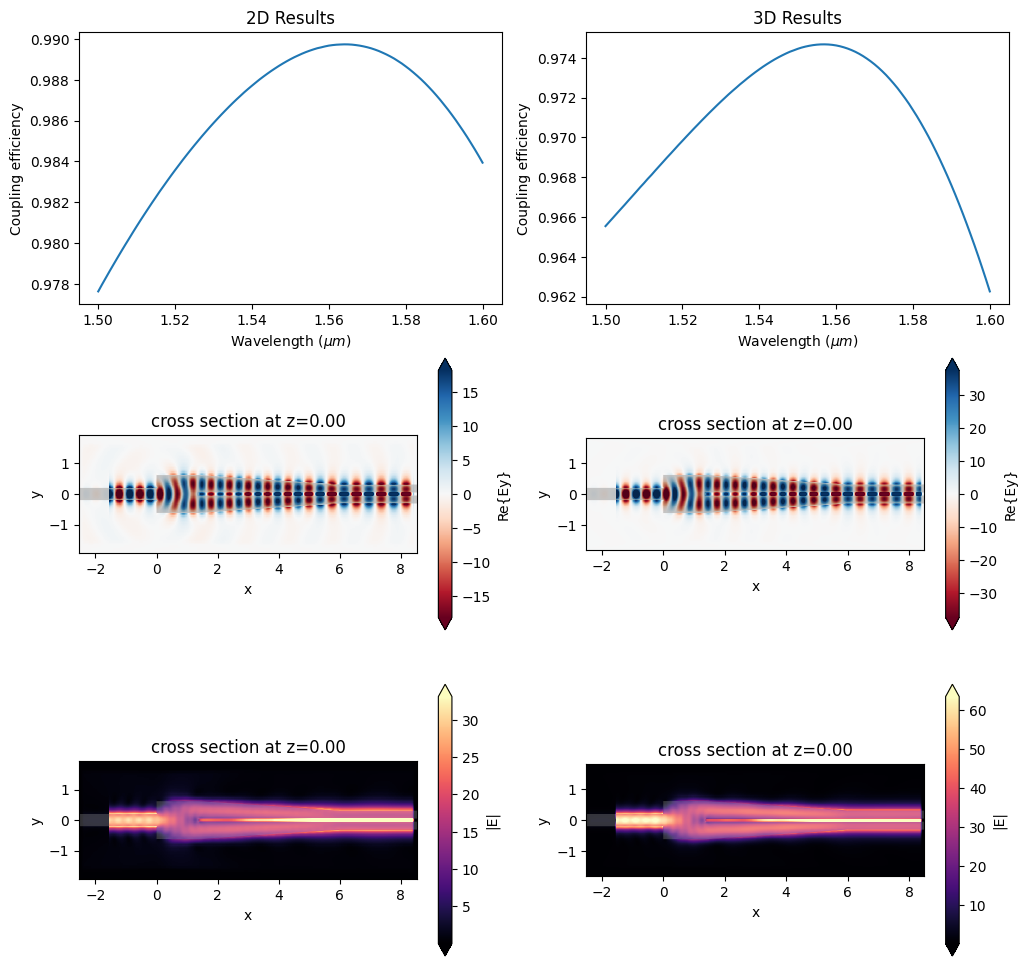

In [10]:
T_2d = np.abs(sim_2d_data["mode"].amps.sel(mode_index=1,direction="+"))**2
T_3d = np.abs(sim_3d_data["mode"].amps.sel(mode_index=0,direction="+"))**2

fig, ax = plt.subplots(3, 2, figsize=(12,12))
ax[0][0].set_title("2D Results")
ax[0][0].set_xlabel("Wavelength ($\mu m$)")
ax[0][0].set_ylabel("Coupling efficiency")
ax[0][0].plot(ldas, T_2d)
sim_2d_data.plot_field(field_monitor_name="field",
                       field_name="Ey",
                       val="real",
                       f=freq0,
                       ax=ax[1][0])
sim_2d_data.plot_field(field_monitor_name="field",
                       field_name="E",
                       val="abs",
                       f=freq0,
                       ax=ax[2][0])
ax[0][1].set_title("3D Results")
ax[0][1].plot(ldas, T_3d)
ax[0][1].set_xlabel("Wavelength ($\mu m$)")
ax[0][1].set_ylabel("Coupling efficiency")
sim_3d_data.plot_field(field_monitor_name="field",
                       field_name="Ey",
                       val="real",
                       f=freq0,
                       ax=ax[1][1])
sim_3d_data.plot_field(field_monitor_name="field",
                       field_name="E",
                       val="abs",
                       f=freq0,
                       ax=ax[2][1])

## Example 2: Waveguide taper



As another example, we will compare results of the linear taper waveguide size converter in our [waveguide size converter notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguideSizeConverter/):

<img src="img/linear_taper.png" width="400" alt="Schematic of the linear taper">

As before, we'll copy the simulation, calculate the 2D mediums, create the 2D simulation, and compare results.

In [8]:
w_in = 10
w_out = 0.5
t_wg = 0.11
inf_eff = 1e3

sub = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)
    ),
    medium=sio2,
)

def linear_taper_sim(L_t):
    vertices = [
        [-inf_eff, w_in / 2],
        [0, w_in / 2],
        [L_t, w_out / 2],
        [inf_eff, w_out / 2],
        [inf_eff, -w_out / 2],
        [L_t, -w_out / 2],
        [0, -w_in / 2],
        [-inf_eff, -w_in / 2],
    ]
    linear_taper = td.Structure(
        geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(0, t_wg)),
        medium=si,
    )
    mode_source = td.ModeSource(
        center=(-lda0 / 2, 0, t_wg / 2),
        size=(0, 1.2 * w_in, 6 * t_wg),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=td.ModeSpec(num_modes=1, target_neff=n_si),
        mode_index=0,
    )
    field_monitor = td.FieldMonitor(
        center=(0, 0, t_wg / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
    )
    flux_monitor = td.FluxMonitor(
        center=(lda0 / 2 + L_t, 0, t_wg / 2),
        size=(0, 2 * w_out, 6 * t_wg),
        freqs=freqs,
        name="flux",
    )
    Lx = L_t + 2 * lda0
    Ly = w_in + 2 * lda0
    Lz = t_wg + 1.5 * lda0
    sim_size = (Lx, Ly, Lz)
    
    run_time = 3e-12

    sim = td.Simulation(
        center=(L_t / 2, 0, t_wg),
        size=sim_size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
        structures=[linear_taper, sub],
        sources=[mode_source],
        monitors=[field_monitor, flux_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(
            boundary=td.PML()
        ),
        symmetry=(0, -1, 0),
    )
    return sim

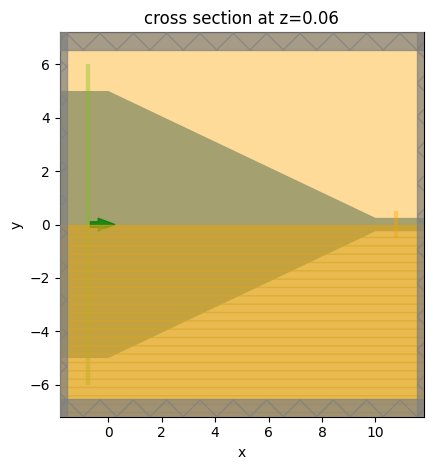

In [9]:
sim2_3d = linear_taper_sim(10)
sim2_3d.plot(z=t_wg / 2)
plt.show()

In [16]:
# Suppress warnings for some of the structures not being included in the 2D simulation
td.config.logging_level = 'ERROR'

step = 3

reference_point = (0,0)
waveguide_eps, background_eps = [], []
for wl in ldas[::step]:
    waveguide_eps.append(var_eps_eff((0,0), reference_point, sim2_3d, wavelength=wl))
    background_eps.append(var_eps_eff((10,4), reference_point, sim2_3d, wavelength=wl))

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/tidy3d/components/types.py:71: ComplexWarning: Casting complex values to real discards the imaginary part
  arr_numpy = np.array(val, ndmin=1, dtype=cls.dtype, copy=True)


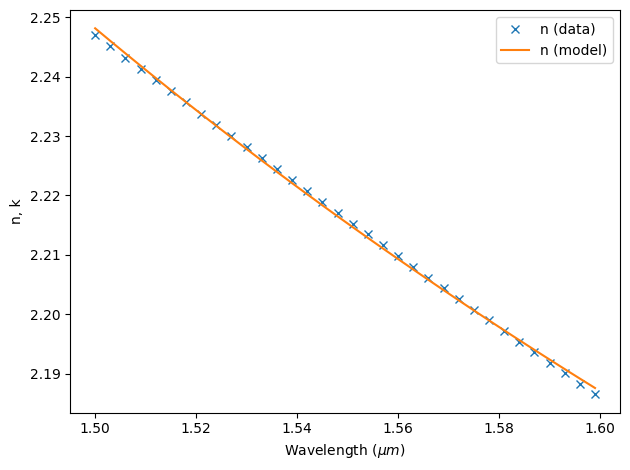

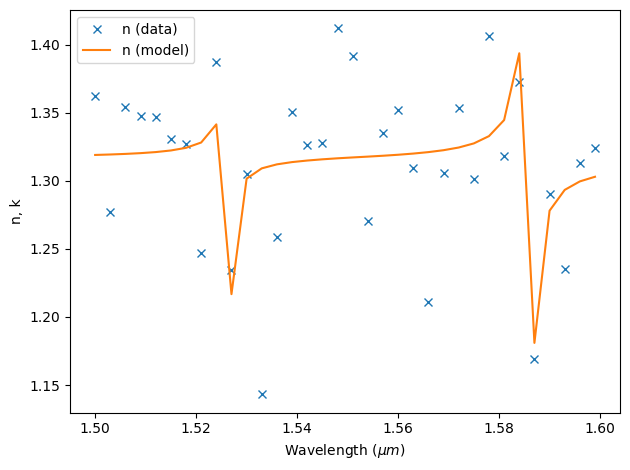

In [17]:
from tidy3d.plugins.dispersion import FastDispersionFitter

waveguide_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(waveguide_eps))
background_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(background_eps))
waveguide_medium, rms_error = waveguide_fitter.fit()
background_medium, rms_error = background_fitter.fit()
waveguide_fitter.plot(waveguide_medium)
background_fitter.plot(background_medium)
plt.show()

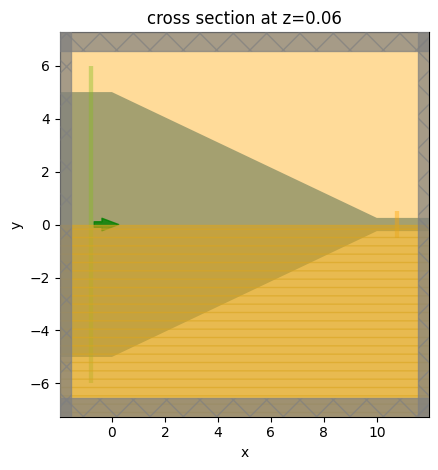

In [23]:
new_structures = []
for structure in sim2_3d.structures:
    new_structures.append(structure.updated_copy(medium=waveguide_medium))

new_center = list(sim2_3d.center)
new_center[2] = t_wg / 2

new_size = list(sim2_3d.size)
new_size[2] = 0

#new_symmetry = list(sim2_3d.symmetry)
#new_symmetry[2] = 0

sim2_2d = sim2_3d.updated_copy(
    center=new_center,
    size=new_size,
    structures=new_structures,
    boundary_spec=sim2_3d.boundary_spec.updated_copy(z=td.Boundary.periodic()),
    medium=background_medium,
    symmetry=new_symmetry
)

sim2_2d.plot(z=t_wg/2)
plt.show()

In [24]:
sim2_2d_data = web.run(sim2_2d, task_name="var eps")
sim2_3d_data = web.run(sim2_3d, task_name="var eps")

19:16:47 PDT Created task 'var eps' with task_id                                
             'fdve-90b7715b-5ed3-4983-a1a9-fa23c2fa9e49' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=769340;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90b7715b-5ed3-4983-a1a9-fa23c2fa9e49\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=381269;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90b7715b-5ed3-4983-a1a9-fa23c2fa9e49\taskId]8;;\]8;id=769340;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90b7715b-5ed3-4983-a1a9-fa23c2fa9e49\=]8;;\]8;id=335588;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90b7715b-5ed3-4983-a1a9-fa23c2fa9e49\fdve]8;;\]8;id=769340;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90b7715b-5ed3-4983-a1a9-fa23c2fa9e49\-90b7715b-5ed]8;;\
             ]8;id=769340;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90b7715b-5ed3-4983-a1a9-fa23c2fa9e49\3-4983-a1a9-fa23c2fa9e49']8;;\.

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

19:16:50 PDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

19:17:02 PDT status = preprocess

19:17:04 PDT Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

19:17:09 PDT early shutoff detected at 16%, exiting.

             status = postprocess

19:17:14 PDT status = success

19:17:15 PDT View simulation result at                                          
             ]8;id=609640;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90b7715b-5ed3-4983-a1a9-fa23c2fa9e49\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=536180;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90b7715b-5ed3-4983-a1a9-fa23c2fa9e49\taskId]8;;\]8;id=609640;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90b7715b-5ed3-4983-a1a9-fa23c2fa9e49\=]8;;\]8;id=238141;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90b7715b-5ed3-4983-a1a9-fa23c2fa9e49\fdve]8;;\]8;id=609640;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90b7715b-5ed3-4983-a1a9-fa23c2fa9e49\-90b7715b-5ed]8;;\
             ]8;id=609640;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90b7715b-5ed3-4983-a1a9-fa23c2fa9e49\3-4983-a1a9-fa23c2fa9e49']8;;\.

19:17:26 PDT loading simulation from simulation_data.hdf5

             Created task 'var eps' with task_id                                
             'fdve-31ce6c2e-aeb2-49e7-8b4d-b1991131da94' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=621898;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31ce6c2e-aeb2-49e7-8b4d-b1991131da94\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=409971;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31ce6c2e-aeb2-49e7-8b4d-b1991131da94\taskId]8;;\]8;id=621898;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31ce6c2e-aeb2-49e7-8b4d-b1991131da94\=]8;;\]8;id=225922;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31ce6c2e-aeb2-49e7-8b4d-b1991131da94\fdve]8;;\]8;id=621898;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31ce6c2e-aeb2-49e7-8b4d-b1991131da94\-31ce6c2e-aeb]8;;\
             ]8;id=621898;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31ce6c2e-aeb2-49e7-8b4d-b1991131da94\2-49e7-8b4d-b1991131da94']8;;\.

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

19:17:29 PDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

19:17:35 PDT status = preprocess

19:17:36 PDT Maximum FlexCredit cost: 0.252. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

19:18:11 PDT early shutoff detected at 16%, exiting.

19:18:12 PDT status = postprocess

19:18:16 PDT status = success

             View simulation result at                                          
             ]8;id=800222;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31ce6c2e-aeb2-49e7-8b4d-b1991131da94\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=697755;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31ce6c2e-aeb2-49e7-8b4d-b1991131da94\taskId]8;;\]8;id=800222;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31ce6c2e-aeb2-49e7-8b4d-b1991131da94\=]8;;\]8;id=3365;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31ce6c2e-aeb2-49e7-8b4d-b1991131da94\fdve]8;;\]8;id=800222;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31ce6c2e-aeb2-49e7-8b4d-b1991131da94\-31ce6c2e-aeb]8;;\
             ]8;id=800222;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31ce6c2e-aeb2-49e7-8b4d-b1991131da94\2-49e7-8b4d-b1991131da94']8;;\.

19:18:21 PDT loading simulation from simulation_data.hdf5

## Example 2 Result Comparison

<Axes: title={'center': 'cross section at z=0.06'}, xlabel='x', ylabel='y'>

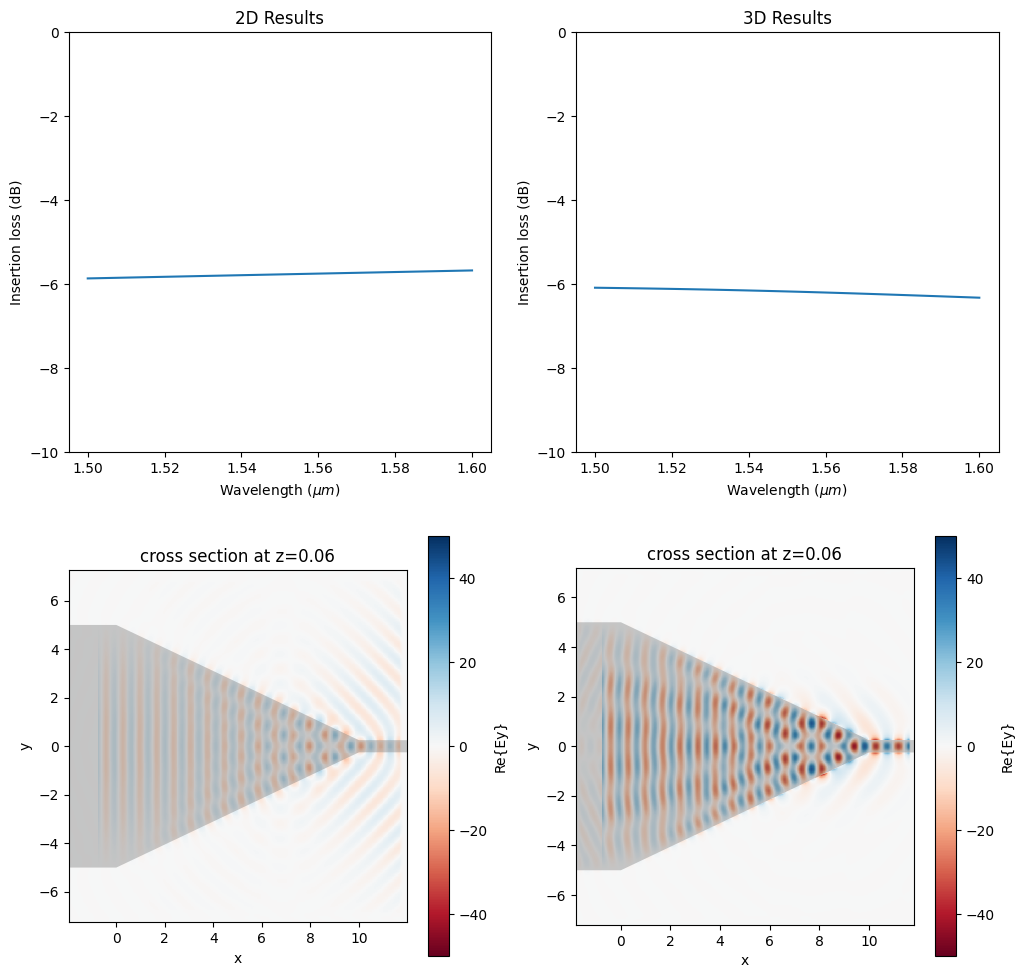

In [29]:
T2_2d = sim2_2d_data["flux"].flux
T2_3d = sim2_3d_data["flux"].flux

fig, ax = plt.subplots(2, 2, figsize=(12,12))
ax[0][0].set_title("2D Results")
ax[0][0].set_ylim((-10,0))
ax[0][0].set_xlabel("Wavelength ($\mu m$)")
ax[0][0].set_ylabel("Insertion loss (dB)")
ax[0][0].plot(ldas, 10*np.log10(T2_2d))
sim2_2d_data.plot_field(field_monitor_name="field",
                       field_name="Ey",
                       f=freq0,
                       ax=ax[1][0],
                       vmin=-50,
                       vmax=50)
ax[0][1].set_title("3D Results")
ax[0][1].set_ylim((-10,0))
ax[0][1].set_xlabel("Wavelength ($\mu m$)")
ax[0][1].set_ylabel("Insertion loss (dB)")
ax[0][1].plot(ldas, 10*np.log10(T2_3d))
sim2_3d_data.plot_field(field_monitor_name="field",
                       field_name="Ey",
                       f=freq0,
                       ax=ax[1][1],
                       vmin=-50,
                       vmax=50)

## Example 2: Y-junction

Next we'll use this method to construct a 2-dimensional analogue of a Y junction, where the 3D version uses a dispersive material model. The Y junction design is taken from [this example notebook](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/YJunction.html):

<img src="img/y_junction_schematic.png" width="600" alt="Schematic of the waveguide Y junction">

In [15]:
si = td.material_library["cSi"]["Palik_Lossless"]
sio2 = td.material_library["SiO2"]["Palik_Lossless"]

In [16]:
t = 0.22  # thickness

w1 = 0.5
w2 = 0.5
w3 = 0.6
w4 = 0.7
w5 = 0.9
w6 = 1.26
w7 = 1.4
w8 = 1.4
w9 = 1.4
w10 = 1.4
w11 = 1.31
w12 = 1.2
w13 = 1.2

l_in = 1
l_junction = 2
l_bend = 6
h_bend = 2
l_out = 1
inf_eff = 100

x = np.linspace(l_in, l_in + l_junction, 13)
y = np.array(
    [w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13]
)

x = np.concatenate((x, np.flipud(x)))
y = np.concatenate((y / 2, -np.flipud(y / 2)))

vertices = np.transpose(np.vstack((x, y)))

junction = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(0, t)), medium=si
)

x_start = l_in + l_junction
x = np.linspace(x_start, x_start + l_bend, 100)
y = (
    (x - x_start) * h_bend / l_bend
    - h_bend * np.sin(2 * np.pi * (x - x_start) / l_bend) / (np.pi * 2)
    + w13 / 2
    - w1 / 2
)
x = np.append(x, inf_eff)
y = np.append(y, y[-1])

cell = gdstk.Cell("bends")
cell.add(gdstk.FlexPath(x + 1j * y, w1, layer=1, datatype=0))
cell.add(gdstk.FlexPath(x - 1j * y, w1, layer=1, datatype=0))
wg_bend_1 = td.Structure(
    geometry=td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(0, t),
    )[0],
    medium=si,
)
wg_bend_2 = td.Structure(
    geometry=td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(0, t),
    )[1],
    medium=si,
)

wg_in = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -w1 / 2, 0), rmax=(l_in, w1 / 2, t)),
    medium=si,
)
y_junction = [wg_in, junction, wg_bend_1, wg_bend_2]

Lx = l_in + l_junction + l_out + l_bend
Ly = w13 + 2 * h_bend + 1.5 * lda0
Lz = 10 * t
sim_size = (Lx, Ly, Lz)

mode_spec = td.ModeSpec(num_modes=1, target_neff=3.5)
mode_source = td.ModeSource(
    center=(l_in / 2, 0, t / 2),
    size=(0, 4 * w1, 6 * t),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

mode_monitor = td.ModeMonitor(
    center=(l_in + l_junction + l_bend + l_out / 2, w13 / 2 - w1 / 2 + h_bend, t / 2),
    size=(0, 4 * w1, 6 * t),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

field_monitor = td.FieldMonitor(
    center=(0, 0, t / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

In [17]:
run_time = 5e-13

simY_3d = td.Simulation(
    center=(Lx / 2, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=y_junction,
    sources=[mode_source],
    monitors=[mode_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
)

In [37]:
# Suppress warnings for some of the structures not being included in the 2D simulation
td.config.logging_level = 'ERROR'

step = 3

reference_point = (2,0)
waveguide_eps, background_eps = [], []
for wl in ldas[::step]:
    waveguide_eps.append(var_eps_eff((2,0), reference_point, simY_3d, wavelength=wl))
    background_eps.append(var_eps_eff((6,0), reference_point, simY_3d, wavelength=wl))

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/tidy3d/components/types.py:71: ComplexWarning: Casting complex values to real discards the imaginary part
  arr_numpy = np.array(val, ndmin=1, dtype=cls.dtype, copy=True)


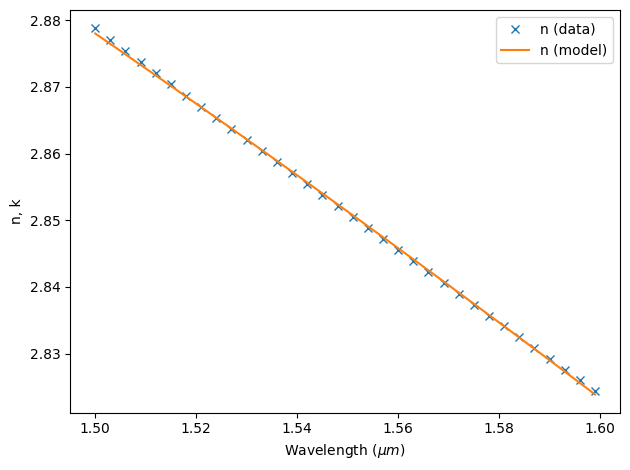

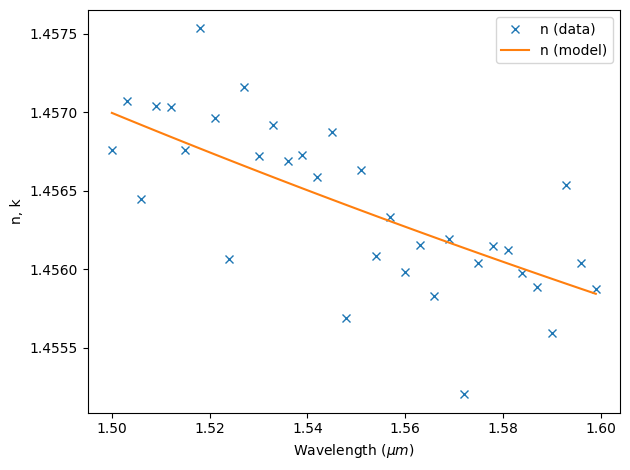

In [38]:
from tidy3d.plugins.dispersion import FastDispersionFitter

waveguide_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(waveguide_eps))
background_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(background_eps))
waveguide_medium, rms_error = waveguide_fitter.fit()
background_medium, rms_error = background_fitter.fit()
waveguide_fitter.plot(waveguide_medium)
background_fitter.plot(background_medium)
plt.show()

In [39]:
new_structures = []
for structure in simY_3d.structures:
    new_structures.append(structure.updated_copy(medium=waveguide_medium))

new_size = list(simY_3d.size)
new_size[2] = 0

simY_2d = simY_3d.updated_copy(
    center=(Lx / 2, 0, t/2),
    size=new_size,
    structures=new_structures,
    boundary_spec=simY_3d.boundary_spec.updated_copy(z=td.Boundary.periodic()),
    medium=background_medium,
)

In [40]:
simY_2d_data = web.run(simY_2d, task_name="var eps")
simY_3d_data = web.run(simY_3d, task_name="var eps")

11:28:24 PDT Created task 'var eps' with task_id                                
             'fdve-5632f662-e58f-4df8-bd83-1f4beced63fd' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=989242;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5632f662-e58f-4df8-bd83-1f4beced63fd\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=62907;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5632f662-e58f-4df8-bd83-1f4beced63fd\taskId]8;;\]8;id=989242;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5632f662-e58f-4df8-bd83-1f4beced63fd\=]8;;\]8;id=810016;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5632f662-e58f-4df8-bd83-1f4beced63fd\fdve]8;;\]8;id=989242;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5632f662-e58f-4df8-bd83-1f4beced63fd\-5632f662-e58]8;;\
             ]8;id=989242;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5632f662-e58f-4df8-bd83-1f4beced63fd\f-4df8-bd83-1f4beced63fd']8;;\.

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

11:28:27 PDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

11:28:32 PDT status = preprocess

11:28:34 PDT Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

11:28:35 PDT running solver

11:28:42 PDT early shutoff detected at 72%, exiting.

11:28:43 PDT status = postprocess

11:28:45 PDT status = success

11:28:46 PDT View simulation result at                                          
             ]8;id=207221;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5632f662-e58f-4df8-bd83-1f4beced63fd\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=250341;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5632f662-e58f-4df8-bd83-1f4beced63fd\taskId]8;;\]8;id=207221;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5632f662-e58f-4df8-bd83-1f4beced63fd\=]8;;\]8;id=335096;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5632f662-e58f-4df8-bd83-1f4beced63fd\fdve]8;;\]8;id=207221;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5632f662-e58f-4df8-bd83-1f4beced63fd\-5632f662-e58]8;;\
             ]8;id=207221;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5632f662-e58f-4df8-bd83-1f4beced63fd\f-4df8-bd83-1f4beced63fd']8;;\.

11:28:50 PDT loading simulation from simulation_data.hdf5

             Created task 'var eps' with task_id                                
             'fdve-815f3d64-d4a4-4861-bda8-16f01de3c21c' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=886764;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815f3d64-d4a4-4861-bda8-16f01de3c21c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=382337;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815f3d64-d4a4-4861-bda8-16f01de3c21c\taskId]8;;\]8;id=886764;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815f3d64-d4a4-4861-bda8-16f01de3c21c\=]8;;\]8;id=115868;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815f3d64-d4a4-4861-bda8-16f01de3c21c\fdve]8;;\]8;id=886764;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815f3d64-d4a4-4861-bda8-16f01de3c21c\-815f3d64-d4a]8;;\
             ]8;id=886764;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815f3d64-d4a4-4861-bda8-16f01de3c21c\4-4861-bda8-16f01de3c21c']8;;\.

/opt/anaconda3/envs/tidy3d_dev/lib/python3.11/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

11:28:53 PDT status = success

11:28:58 PDT loading simulation from simulation_data.hdf5

## Example 3 Result Comparison

<Axes: title={'center': 'cross section at z=0.11'}, xlabel='x', ylabel='y'>

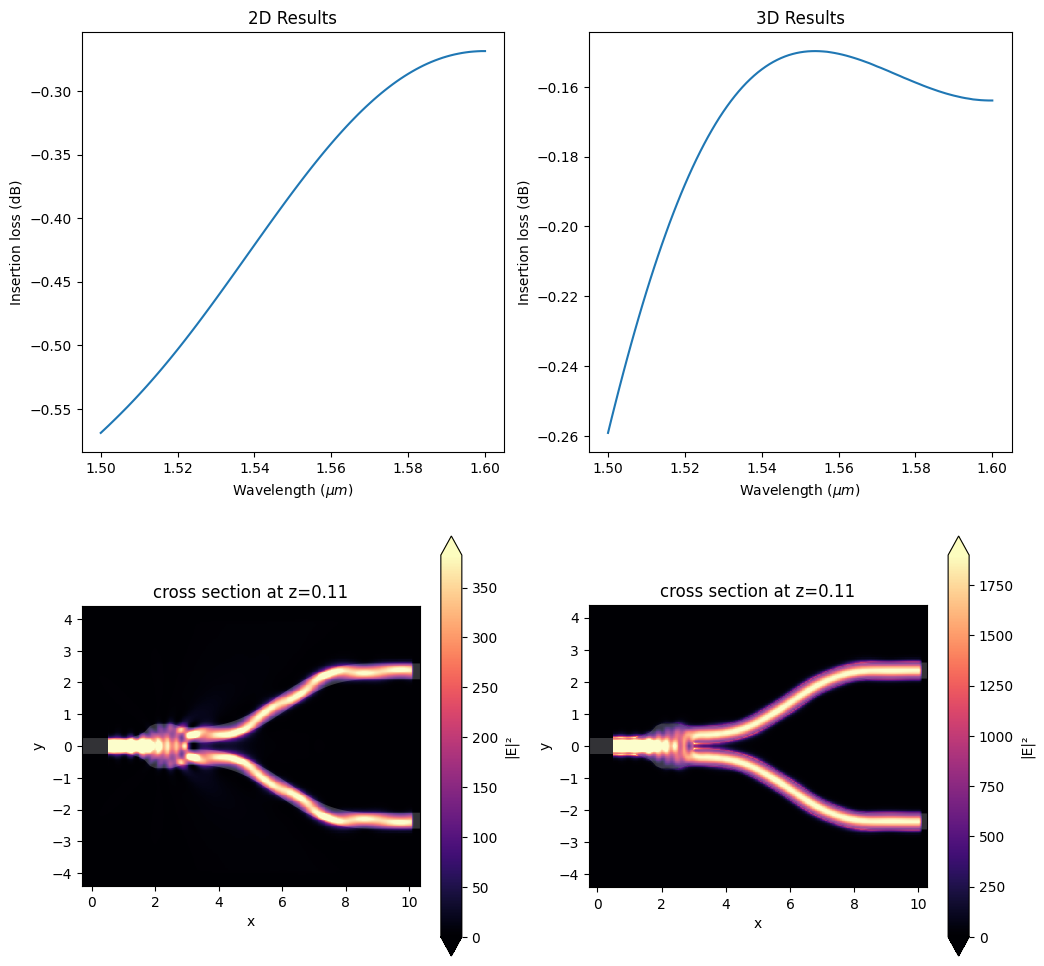

In [41]:
amp2d = simY_2d_data["mode"].amps.sel(mode_index=0, direction="+")
amp3d = simY_3d_data["mode"].amps.sel(mode_index=0, direction="+")
loss2d = 10*np.log10(2*np.abs(amp2d)**2)
loss3d = 10*np.log10(2*np.abs(amp3d)**2)

fig, ax = plt.subplots(2, 2, figsize=(12,12))

ax[0][0].set_title("2D Results")
ax[0][0].plot(ldas, loss2d)
ax[0][0].set_xlabel("Wavelength ($\mu m$)")
ax[0][0].set_ylabel("Insertion loss (dB)")
simY_2d_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2", f=freq0, ax=ax[1][0])

ax[0][1].set_title("3D Results")
ax[0][1].plot(ldas, loss3d)
ax[0][1].set_xlabel("Wavelength ($\mu m$)")
ax[0][1].set_ylabel("Insertion loss (dB)")
simY_3d_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2", f=freq0, ax=ax[1][1])

## Summation

For transmissions and other relevant quantities for components such as these, this 2D method returns rather similar results to its 3D counterpart, and should allow for a cheap way to screen early designs of such components.